In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [14]:
# 1. Configuration
# ─────────────────────────────────────────────────────────────────────────────

DATA_PATH     = "Cleaned_Tickets.csv"      # your CSV with columns "text" and "tags"
MAX_VOCAB_SZ  = 20_000
MAX_SEQ_LEN   = 100
EMBED_DIM     = 128
HIDDEN_DIM    = 256
NUM_LAYERS    = 1
DROPOUT       = 0.1
BATCH_SIZE    = 32
LR            = 1e-3
NUM_EPOCHS    = 15
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH    = "bilstm_attn_best.pt"

In [15]:
# 2. Load & preprocess data
# ─────────────────────────────────────────────────────────────────────────────

df = pd.read_csv(DATA_PATH)  # expects columns "text" (str) and "tags" (pipe-separated)
# build tag set
df["text"] = df["subject"].str.strip() + " " + df["body"].str.strip()

# Build list of tags
df["tags_list"] = df[["tag_1", "tag_2", "tag_3"]].values.tolist()
all_tags = sorted({t for lst in df["tags_list"] for t in lst})
tag2idx  = {t:i for i,t in enumerate(all_tags)}

# a more flexible encoder that works on either a list or a pipe-string
def encode_tags(ts):
    if isinstance(ts, str):
        tags = ts.split("|")
    else:
        tags = ts         # assume it’s already a list
    vec = np.zeros(len(all_tags), dtype=int)
    for t in tags:
        vec[tag2idx[t]] = 1
    return vec

# map over the column that actually holds your lists
df["label_vec"] = df["tags_list"].map(encode_tags)

# now split into train/val/test as before
X_train, X_tmp, y_train, y_tmp = train_test_split(
    df["text"].tolist(), np.vstack(df["label_vec"]), 
    test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42
)

# and rebuild your vocab…
counter = Counter()
for text in X_train:
    counter.update(text.lower().split())
vocab = {"<PAD>":0, "<UNK>":1}
for i,(word,_) in enumerate(counter.most_common(MAX_VOCAB_SZ), start=2):
    vocab[word] = i
VOCAB_SIZE = len(vocab)

In [16]:
# 3. Dataset & DataLoader
# ─────────────────────────────────────────────────────────────────────────────

class TicketDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts, self.labels = texts, labels
        self.vocab, self.max_len = vocab, max_len

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        tokens = self.texts[idx].lower().split()[:self.max_len]
        seq = [ self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens ]
        # pad
        seq += [self.vocab["<PAD>"]] * (self.max_len - len(seq))
        return torch.LongTensor(seq), torch.FloatTensor(self.labels[idx])

train_ds = TicketDataset(X_train, y_train, vocab, MAX_SEQ_LEN)
val_ds   = TicketDataset(X_val,   y_val,   vocab, MAX_SEQ_LEN)
test_ds  = TicketDataset(X_test,  y_test,  vocab, MAX_SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

In [17]:
# 4. Model: BiLSTM + Attention
# ─────────────────────────────────────────────────────────────────────────────

class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, layers, dropout, n_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=layers,
            bidirectional=True, batch_first=True,
            dropout=dropout if layers>1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        # attention
        self.attn_proj = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.attn_vec  = nn.Parameter(torch.randn(2*hidden_dim))
        # final
        self.fc = nn.Linear(2*hidden_dim, n_labels)

    def forward(self, x):
        emb, _ = self.embedding(x), None
        out, _ = self.lstm(emb)                     # [B, L, 2H]
        u     = torch.relu(self.attn_proj(out))     # ReLU in proj
        scores= (u @ self.attn_vec).softmax(dim=1).unsqueeze(-1)  # [B,L,1]
        feat  = (scores * out).sum(dim=1)           # [B,2H]
        feat  = self.dropout(feat)
        return self.fc(feat)                        # logits

model = BiLSTMAttention(
    VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM,
    NUM_LAYERS, DROPOUT, len(all_tags)
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [18]:
# 5. Train / Eval functions
# ─────────────────────────────────────────────────────────────────────────────

def train_epoch():
    model.train()
    total_loss = 0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(seqs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * seqs.size(0)
    return total_loss / len(train_ds)

def run_eval(loader, thresholds=None):
    model.eval()
    losses, all_probs, all_labels = 0, [], []
    with torch.no_grad():
        for seqs, labels in loader:
            seqs, labels = seqs.to(DEVICE), labels.to(DEVICE)
            logits = model(seqs)
            losses+= criterion(logits, labels).item() * seqs.size(0)
            all_probs.append(torch.sigmoid(logits).cpu())
            all_labels.append(labels.cpu())
    probs  = torch.cat(all_probs).numpy()
    y_true = torch.cat(all_labels).numpy()
    if thresholds is None:
        preds = (probs >= 0.5).astype(int)
    else:
        preds = (probs >= thresholds).astype(int)
    return {
        "loss":    losses/len(loader.dataset),
        "precision": precision_score(y_true, preds, average="micro", zero_division=0),
        "recall":    recall_score(y_true, preds, average="micro", zero_division=0),
        "f1":        f1_score(y_true, preds, average="micro", zero_division=0),
        "y_true":    y_true,
        "y_pred":    preds,
        "probs":     probs
    }

In [19]:
# 6. Threshold Tuning
# ─────────────────────────────────────────────────────────────────────────────

def tune_threshold(val_loader):
    res = run_eval(val_loader)
    best_thr, best_f1 = 0.5, -1
    for thr in np.arange(0.1, 1.0, 0.01):
        pred = (res["probs"] >= thr).astype(int)
        f1 = f1_score(res["y_true"], pred, average="micro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    print(f"→ Best threshold = {best_thr:.2f} with micro-F1 = {best_f1:.4f}")
    return np.full(len(all_tags), best_thr)

In [20]:
# 7. Training loop
# ─────────────────────────────────────────────────────────────────────────────

best_f1 = -1
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(1, NUM_EPOCHS+1):
    tr_loss = train_epoch()
    ev = run_eval(val_loader)
    train_losses.append(tr_loss)
    val_losses.append(ev["loss"])
    val_f1s.append(ev["f1"])

    if ev["f1"] > best_f1:
        best_f1 = ev["f1"]
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"\nEpoch {epoch}: new best val f1 {best_f1:.4f} → saved")

    print(
        f"Epoch {epoch:2d} | "
        f"Train Loss: {tr_loss:.4f} | Val Loss: {ev['loss']:.4f} | "
        f"Val F1: {ev['f1']:.4f}  P: {ev['precision']:.4f}  R: {ev['recall']:.4f}"
    )


Epoch 1: new best val f1 0.1286 → saved
Epoch  1 | Train Loss: 0.0377 | Val Loss: 0.0239 | Val F1: 0.1286  P: 0.7921  R: 0.0700

Epoch 2: new best val f1 0.4555 → saved
Epoch  2 | Train Loss: 0.0210 | Val Loss: 0.0193 | Val F1: 0.4555  P: 0.7271  R: 0.3316

Epoch 3: new best val f1 0.4701 → saved
Epoch  3 | Train Loss: 0.0187 | Val Loss: 0.0185 | Val F1: 0.4701  P: 0.7456  R: 0.3433

Epoch 4: new best val f1 0.5302 → saved
Epoch  4 | Train Loss: 0.0181 | Val Loss: 0.0176 | Val F1: 0.5302  P: 0.7260  R: 0.4176

Epoch 5: new best val f1 0.5685 → saved
Epoch  5 | Train Loss: 0.0170 | Val Loss: 0.0169 | Val F1: 0.5685  P: 0.7346  R: 0.4637

Epoch 6: new best val f1 0.5917 → saved
Epoch  6 | Train Loss: 0.0164 | Val Loss: 0.0164 | Val F1: 0.5917  P: 0.7442  R: 0.4910

Epoch 7: new best val f1 0.6066 → saved
Epoch  7 | Train Loss: 0.0158 | Val Loss: 0.0159 | Val F1: 0.6066  P: 0.7632  R: 0.5033

Epoch 8: new best val f1 0.6107 → saved
Epoch  8 | Train Loss: 0.0153 | Val Loss: 0.0157 | Val F

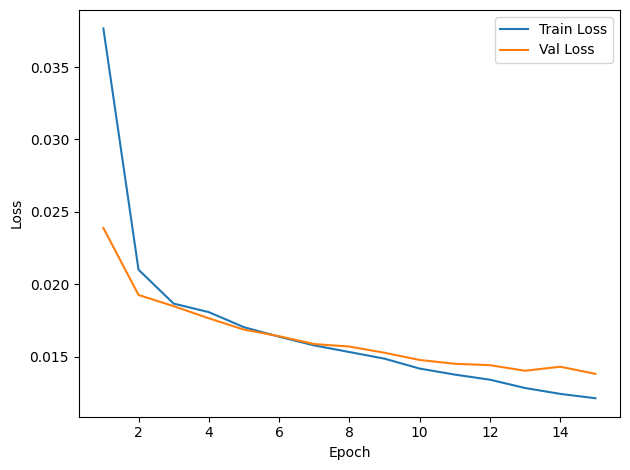

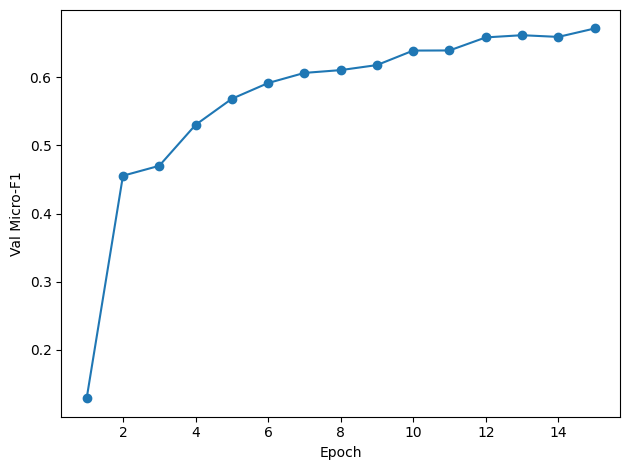

In [21]:
# 8. Plot training curves
# ─────────────────────────────────────────────────────────────────────────────

plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1),   val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure()
plt.plot(range(1, len(val_f1s)+1), val_f1s, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Val Micro-F1"); plt.tight_layout()
plt.show()

In [22]:
# 9. Load best & evaluate on test
# ─────────────────────────────────────────────────────────────────────────────

model.load_state_dict(torch.load(MODEL_PATH))
best_threshs = tune_threshold(val_loader)

test_res = run_eval(test_loader, thresholds=best_threshs)
print("\n--- Test Results with tuned thresholds ---")
print(f"Precision: {test_res['precision']:.4f}")
print(f"Recall   : {test_res['recall']:.4f}")
print(f"Micro F1 : {test_res['f1']:.4f}")
macro_f1 = f1_score(test_res["y_true"], test_res["y_pred"], average="macro", zero_division=0)
print(f"Macro F1 : {macro_f1:.4f}\n")

print("Per-tag performance:")
print(classification_report(
    test_res["y_true"], test_res["y_pred"],
    target_names=all_tags, zero_division=0
))

→ Best threshold = 0.38 with micro-F1 = 0.6822

--- Test Results with tuned thresholds ---
Precision: 0.7046
Recall   : 0.6565
Micro F1 : 0.6797
Macro F1 : 0.0464

Per-tag performance:
                           precision    recall  f1-score   support

                       AI       0.00      0.00      0.00         0
                      API       0.00      0.00      0.00         0
          API Integration       0.00      0.00      0.00         0
                      AWS       0.00      0.00      0.00         0
                   Access       0.00      0.00      0.00         1
           Access Control       0.00      0.00      0.00         0
        Access Management       0.00      0.00      0.00         1
            Accessibility       0.00      0.00      0.00         0
                  Account       0.56      0.29      0.38        35
                 Accuracy       0.00      0.00      0.00         0
           ActiveCampaign       0.00      0.00      0.00         1
          